In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
data_dir = r'..\data\cleansed\\'
file_name = 'data_eda.csv'
df = pd.read_csv(data_dir+file_name)
df.sample(5)

,person,gender,age,became_member_on,bmo_year,income,amount_sum,amount_mean,offer received,offer viewed,offer completed,age_group,income_group,bogo,discount,informational,chance bogo,chance discount,chance informational
10493,be36abf9679d4981963d4af7d14eeafe,M,48,2017-12-03,2017,45000.0,12.32,2.464000,6.0,2.0,0.0,Older,Lower-Middle,NaN,0.000000,66.666667,Low,Low,High
212,0409252539634eca8a8d1b5407caa582,M,32,2017-09-25,2017,39000.0,99.62,24.905000,3.0,3.0,0.0,Youth,Lower-Middle,0.0,NaN,50.000000,Low,Low,Low
283,055640cd12d04eb4b8a51ec67d451fc7,F,39,2016-11-24,2016,38000.0,213.23,9.270870,5.0,4.0,4.0,Middle,Lower-Middle,NaN,100.000000,0.000000,Low,High,Low
4135,4b9a3bf77bb64f4ca41e314aa24fc36a,F,46,2017-09-01,2017,72000.0,155.30,22.185714,4.0,4.0,4.0,Middle,Lower-Middle,100.0,66.666667,NaN,High,High,Low
534,0a0e0f2c65304dd2ae36d854baac2cbe,F,34,2017-10-16,2017,63000.0,207.99,14.856429,6.0,5.0,4.0,Youth,Lower-Middle,50.0,50.000000,50.000000,Low,Low,Low


Before we get started, we will first try to see at a glance how the condition of our data is currently.

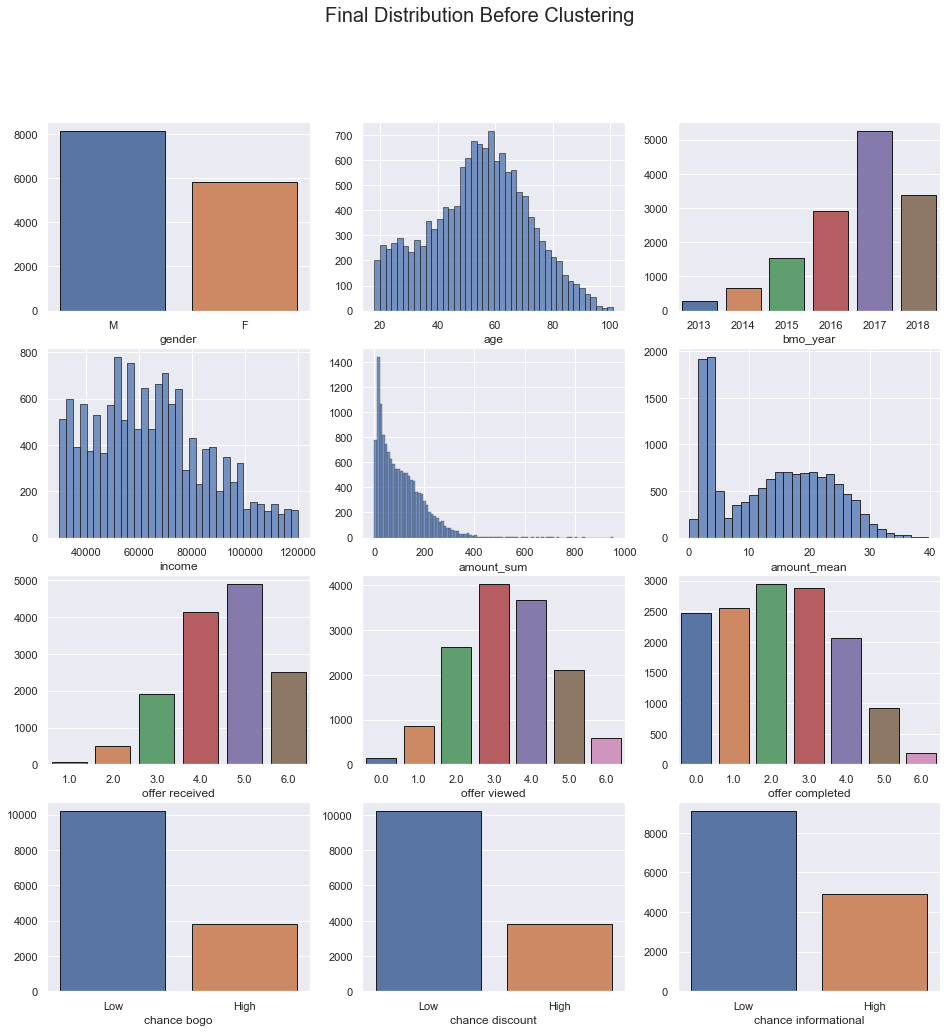

In [3]:
fig_dir = r'..\result\figure\\'
fig_title = 'Final Distribution Before Clustering'

fig, axs = plt.subplots(4,3, figsize=(16,16))
fig.suptitle(fig_title, fontsize=20)

sns.countplot(ax=axs[0,0], data=df, x='gender', edgecolor='k')
sns.histplot(ax=axs[0,1], data=df, x='age', edgecolor='k')
sns.countplot(ax=axs[0,2], data=df, x='bmo_year', edgecolor='k')
sns.histplot(ax=axs[1,0], data=df, x='income', edgecolor='k')
sns.histplot(ax=axs[1,1], data=df, x='amount_sum', edgecolor='k')
sns.histplot(ax=axs[1,2], data=df, x='amount_mean', edgecolor='k')
sns.countplot(ax=axs[2,0], data=df, x='offer received', edgecolor='k')
sns.countplot(ax=axs[2,1], data=df, x='offer viewed', edgecolor='k')
sns.countplot(ax=axs[2,2], data=df, x='offer completed', edgecolor='k')
sns.countplot(ax=axs[3,0], data=df, x='chance bogo', edgecolor='k')
sns.countplot(ax=axs[3,1], data=df, x='chance discount', edgecolor='k')
sns.countplot(ax=axs[3,2], data=df, x='chance informational', edgecolor='k', order=['Low', 'High'])

axs[0,0].set_ylabel('')
axs[0,1].set_ylabel('')
axs[0,2].set_ylabel('')
axs[1,0].set_ylabel('')
axs[1,1].set_ylabel('')
axs[1,2].set_ylabel('')
axs[2,0].set_ylabel('')
axs[2,1].set_ylabel('')
axs[2,2].set_ylabel('')
axs[3,0].set_ylabel('')
axs[3,1].set_ylabel('')
axs[3,2].set_ylabel('')


plt.savefig(fig_dir+fig_title+'.png')
plt.show()

Since K-Means work better for numerical features, we will only use these columns for clustering purpose:
* age
* bmo_year
* income
* amount_sum
* amount_mean
* offer received
* offer viewed
* offer completed
* chance bogo (in numeric)
* chance discount (in numeric)
* chance informational (in numeric)

In [4]:
features = df[['age','bmo_year','income','amount_sum','amount_mean', 
              'bogo', 'discount', 'informational']]
features = features.fillna(0)

features.describe()

,age,bmo_year,income,amount_sum,amount_mean,bogo,discount,informational
count,14002.000000,14002.000000,14002.000000,14002.000000,14002.000000,14002.000000,14002.000000,14002.000000
mean,54.240894,2016.600843,65033.780888,107.035041,13.630012,34.361877,35.284245,38.684831
std,17.464301,1.203467,21613.801585,89.345178,9.014319,40.519835,40.015181,46.112468
min,18.000000,2013.000000,30000.000000,0.150000,0.150000,0.000000,0.000000,0.000000
25%,42.000000,2016.000000,48000.000000,33.282500,3.809063,0.000000,0.000000,0.000000
50%,55.000000,2017.000000,63000.000000,87.340000,14.005000,0.000000,25.000000,0.000000
75%,66.000000,2017.000000,79000.000000,157.807500,21.100500,66.666667,66.666667,100.000000
max,101.000000,2018.000000,120000.000000,953.390000,39.646667,100.000000,100.000000,100.000000


## Scaling Numerical Features

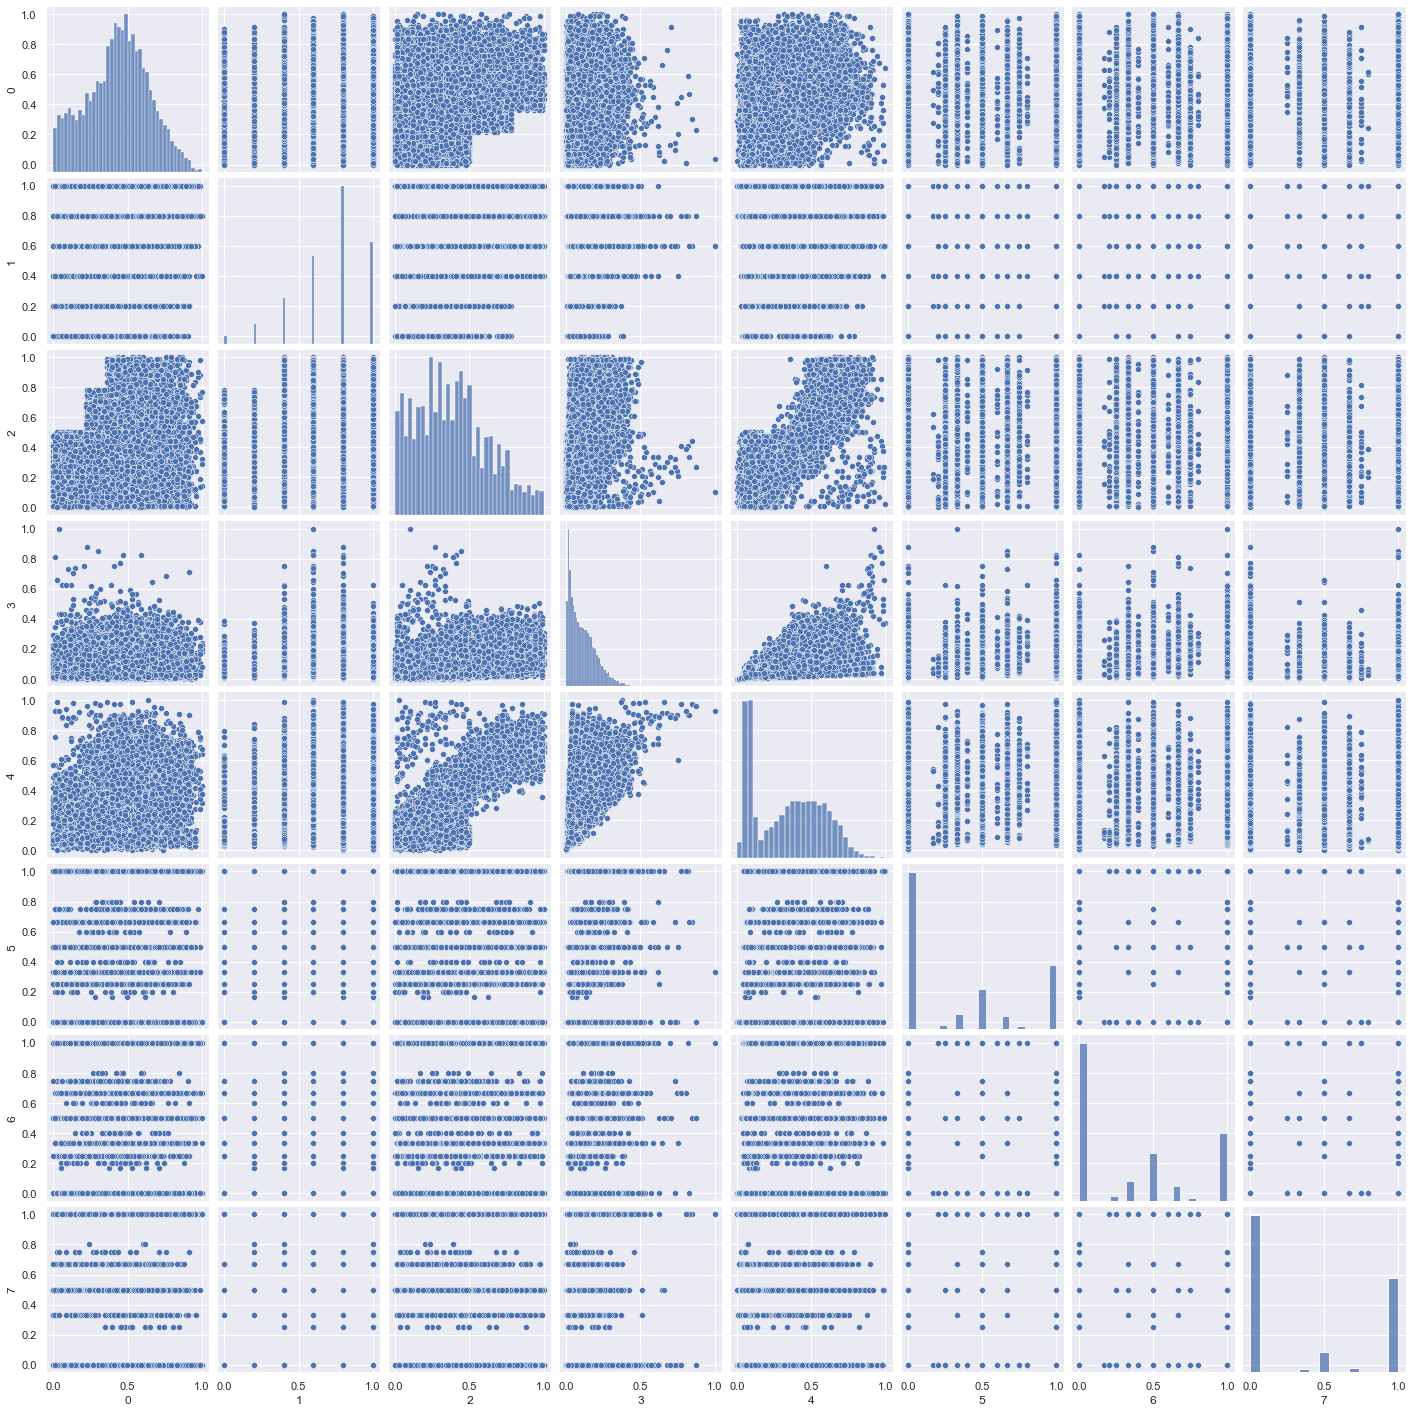

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features.astype(float))

sns.pairplot(pd.DataFrame(scaled_features))

## Determine The Best Number of Cluster

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Elbow Method

From [Real Python](https://realpython.com/k-means-clustering-python/#choosing-the-appropriate-number-of-clusters):

"The SSE is defined as the sum of the squared Euclidean distances of each point to its closest centroid. Since this is a measure of error, the objective of k-means is to try to minimize this value."

In [7]:
kmeans_kwargs = {
    "init": "random",
    "n_init" : 10,
    "max_iter" : 300,
    "random_state" : 69,
}

sse = []
clusters_sse = range(1,11)

for k in clusters_sse:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

### Silhouette Method

From [Real Python](https://realpython.com/k-means-clustering-python/#choosing-the-appropriate-number-of-clusters):

"The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

1. How close the data point is to other points in the cluster
2. How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters."

In [8]:
silhouette = []
clusters_silhouette = range(2,11)

for k in clusters_silhouette:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette.append(score)

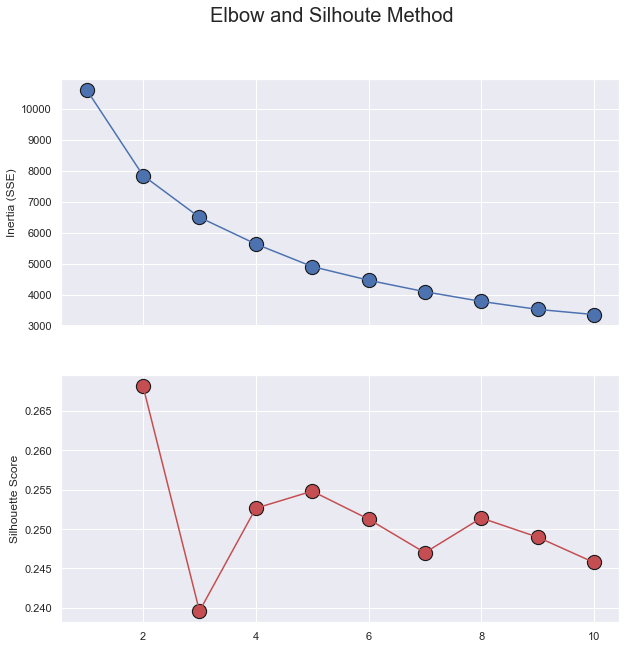

In [9]:
fig_dir = r'..\result\figure\\'
fig_title = 'Elbow and Silhoute Method'

fig, axs = plt.subplots(2,1, figsize=(10,10), sharex=True)
fig.suptitle(fig_title, fontsize=20)

sns.lineplot(ax=axs[0],x=clusters_sse, y=sse)
sns.scatterplot(ax=axs[0],x=clusters_sse, y=sse, s=200, color='b', edgecolor='k')

sns.lineplot(ax=axs[1],x=clusters_silhouette, y=silhouette, color='r')
sns.scatterplot(ax=axs[1],x=clusters_silhouette, y=silhouette, s=200, color='r', edgecolor='k')

axs[0].set_ylabel('Inertia (SSE)')
axs[1].set_ylabel('Silhouette Score')

plt.savefig(fig_dir+fig_title+'.png')
plt.show()

The inertia scoring doesn't give us much information since sudden fall happen in number of cluster 2.<br>
But from silhouette method we get that when the number of cluster is 5, we get relatively high score supporting by the suifficient small score in inertia.<br>
From this observation, we choose the number of cluster that we will use is 5.

## Perform Clustering

In [10]:
kmeans = KMeans(init='random',
               n_clusters=5,
               n_init=10,
               max_iter=300,
               random_state=69)
kmeans.fit(scaled_features)

print('The KMeans need {0:.1f} iterations' .format(kmeans.n_iter_))

The KMeans need 13.0 iterations


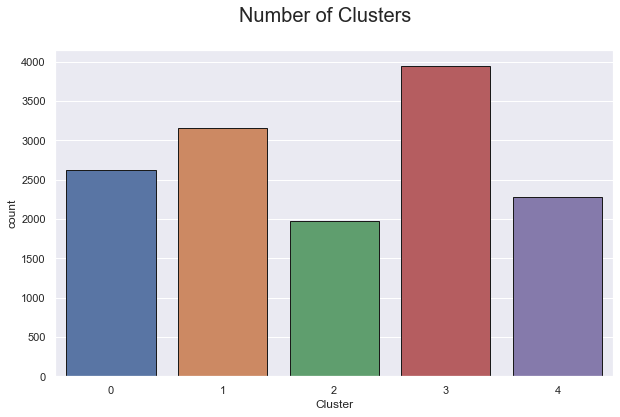

In [13]:
df['Cluster'] = kmeans.labels_

fig_dir = r'..\result\figure\\'
fig_title = 'Number of Clusters'

fig, axs = plt.subplots(1,1, figsize=(10,6))
fig.suptitle(fig_title, fontsize=20)

sns.countplot(data=df, x='Cluster', edgecolor='k')

plt.savefig(fig_dir+fig_title+'.png')
plt.show()

In [12]:
data_dir = r'..\data\cleansed\\'
file_name = 'data_clusters.csv'

df.to_csv(data_dir+file_name, index=False, header=True)

## Explore Clusters